In [ ]:
import os
import re
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar10'
model_dir = '/ssd/yl38u22/'  

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


test_dataset = datasets.CIFAR10(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


def create_model():
    model = torchvision.models.resnet18()
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 10)
    return model.to(device)


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_targets


model_files = []
for method_prefix in ['cutmix', 'fmix_orig', 'smix']:
    files = glob.glob(os.path.join(model_dir, f'cifar10_{method_prefix}_seed*_lr0.1.pt'))
    model_files.extend(files)

model_groups = defaultdict(list)
for path in model_files:
    filename = os.path.basename(path)
    

    method_match = re.search(r'cifar10_([a-z_]+)_seed', filename)
    seed_match = re.search(r'_seed(\d+)', filename)
    
    if method_match and seed_match:
        method = method_match.group(1)
        seed = int(seed_match.group(1))
        model_groups[method].append((seed, path))
    else:
        print(f"跳过格式不匹配的文件: {filename}")


results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    for seed, path in tqdm(seeds_paths, desc=f'Evaluating {method}', leave=False):
        model = create_model()
        model.load_state_dict(torch.load(path, map_location=device))
        
        accuracy, preds, targets = evaluate_model(model, test_loader)
        
        results.append({
            'Method': method,
            'Seed': seed,
            'Accuracy': accuracy,
            'Predictions': preds,
            'Targets': targets
        })


df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', data=df, ci='sd', capsize=0.1)
plt.title('Test Accuracy Comparison (Mean ± SD)')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 95)  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Accuracy', data=df)
sns.swarmplot(x='Method', y='Accuracy', data=df, color='black', alpha=0.5)
plt.title('Accuracy Distribution by Method')
plt.ylabel('Accuracy (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

stats_df = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("Detailed Statistics:")
display(stats_df.style.format({'mean': '{:.2f}%', 'std': '{:.2f}%', 
                              'min': '{:.2f}%', 'max': '{:.2f}%'}))


last_result = results[-1]
cm = confusion_matrix(last_result['Targets'], last_result['Predictions'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title(f'Confusion Matrix Example ({last_result["Method"]} - Seed {last_result["Seed"]})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print("\nClassification Report Example:")
print(classification_report(last_result['Targets'], last_result['Predictions'], 
                            target_names=test_dataset.classes, digits=4))


plt.figure(figsize=(12, 6))
for method in df['Method'].unique():
    method_df = df[df['Method'] == method]
    plt.plot(method_df['Seed'], method_df['Accuracy'], 
             marker='o', linestyle='--', label=method)
    
plt.title('Accuracy Across Different Seeds')
plt.xlabel('Seed')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Files already downloaded and verified


NameError: name 'glob' is not defined

In [ ]:
import os
import re
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar10'
model_dir = '/ssd/yl38u22/'  


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


test_dataset = datasets.CIFAR10(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

def create_model():
    model = torchvision.models.resnet18()
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 10)
    return model.to(device)


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_targets


model_files = []
for method_prefix in ['cutmix', 'fmix_orig', 'smix']:
    files = glob.glob(os.path.join(model_dir, f'cifar10_{method_prefix}_seed*_lr0.1.pt'))
    model_files.extend(files)


model_groups = defaultdict(list)
for path in model_files:
    filename = os.path.basename(path)
    

    method_match = re.search(r'cifar10_([a-z_]+)_seed', filename)
    seed_match = re.search(r'_seed(\d+)', filename)
    
    if method_match and seed_match:
        method = method_match.group(1)
        seed = int(seed_match.group(1))
        model_groups[method].append((seed, path))
    else:
        print(f"跳过格式不匹配的文件: {filename}")


results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    for seed, path in tqdm(seeds_paths, desc=f'Evaluating {method}', leave=False):
        model = create_model()
        model.load_state_dict(torch.load(path, map_location=device))
        
        accuracy, preds, targets = evaluate_model(model, test_loader)
        
        results.append({
            'Method': method,
            'Seed': seed,
            'Accuracy': accuracy,
            'Predictions': preds,
            'Targets': targets
        })

# 转换为DataFrame
df = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', data=df, ci='sd', capsize=0.1)
plt.title('Test Accuracy Comparison (Mean ± SD)')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 95)  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Accuracy', data=df)
sns.swarmplot(x='Method', y='Accuracy', data=df, color='black', alpha=0.5)
plt.title('Accuracy Distribution by Method')
plt.ylabel('Accuracy (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


stats_df = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("Detailed Statistics:")
display(stats_df.style.format({'mean': '{:.2f}%', 'std': '{:.2f}%', 
                              'min': '{:.2f}%', 'max': '{:.2f}%'}))


last_result = results[-1]
cm = confusion_matrix(last_result['Targets'], last_result['Predictions'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title(f'Confusion Matrix Example ({last_result["Method"]} - Seed {last_result["Seed"]})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print("\nClassification Report Example:")
print(classification_report(last_result['Targets'], last_result['Predictions'], 
                            target_names=test_dataset.classes, digits=4))


plt.figure(figsize=(12, 6))
for method in df['Method'].unique():
    method_df = df[df['Method'] == method]
    plt.plot(method_df['Seed'], method_df['Accuracy'], 
             marker='o', linestyle='--', label=method)
    
plt.title('Accuracy Across Different Seeds')
plt.xlabel('Seed')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import re
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar10'
model_dir = '/ssd/yl38u22/' 


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


test_dataset = datasets.CIFAR10(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


def create_model():
    model = torchvision.models.resnet18()
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 10)
    return model.to(device)


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_targets


model_files = []
for method_prefix in ['cutmix', 'fmix_orig', 'smix']:
    files = glob.glob(os.path.join(model_dir, f'cifar10_{method_prefix}_seed*_lr0.1.pt'))
    model_files.extend(files)

model_groups = defaultdict(list)
for path in model_files:
    filename = os.path.basename(path)
    

    method_match = re.search(r'cifar10_([a-z_]+)_seed', filename)
    seed_match = re.search(r'_seed(\d+)', filename)
    
    if method_match and seed_match:
        method = method_match.group(1)
        seed = int(seed_match.group(1))
        model_groups[method].append((seed, path))
    else:
        print(f"跳过格式不匹配的文件: {filename}")


results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    for seed, path in tqdm(seeds_paths, desc=f'Evaluating {method}', leave=False):
        model = create_model()
        model.load_state_dict(torch.load(path, map_location=device))
        
        accuracy, preds, targets = evaluate_model(model, test_loader)
        
        results.append({
            'Method': method,
            'Seed': seed,
            'Accuracy': accuracy,
            'Predictions': preds,
            'Targets': targets
        })

df = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', data=df, ci='sd', capsize=0.1)
plt.title('Test Accuracy Comparison (Mean ± SD)')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 95)  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Accuracy', data=df)
sns.swarmplot(x='Method', y='Accuracy', data=df, color='black', alpha=0.5)
plt.title('Accuracy Distribution by Method')
plt.ylabel('Accuracy (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


stats_df = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("Detailed Statistics:")
display(stats_df.style.format({'mean': '{:.2f}%', 'std': '{:.2f}%', 
                              'min': '{:.2f}%', 'max': '{:.2f}%'}))

last_result = results[-1]
cm = confusion_matrix(last_result['Targets'], last_result['Predictions'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title(f'Confusion Matrix Example ({last_result["Method"]} - Seed {last_result["Seed"]})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print("\nClassification Report Example:")
print(classification_report(last_result['Targets'], last_result['Predictions'], 
                            target_names=test_dataset.classes, digits=4))


plt.figure(figsize=(12, 6))
for method in df['Method'].unique():
    method_df = df[df['Method'] == method]
    plt.plot(method_df['Seed'], method_df['Accuracy'], 
             marker='o', linestyle='--', label=method)
    
plt.title('Accuracy Across Different Seeds')
plt.xlabel('Seed')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Files already downloaded and verified


Evaluating cutmix:   0%|                                                                          | 0/5 [00:00<?, ?it/s]Using cache found in /home/yl38u22/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2370566/2753767239.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pi

/tmp/ipykernel_2370566/2753767239.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'count', 'min', 'max'])


Performance Statistics:
          Mean Std Dev  Runs    Min    Max
Method                                    
fmix    94.83%   0.27%     5 94.36% 95.01%
smix    93.66%   0.29%     5 93.40% 94.03%
mixup   92.57%   0.17%     5 92.39% 92.84%
vanilla 89.96%   0.27%     5 89.69% 90.38%
cutmix  93.16%   0.07%     5 93.07% 93.25%


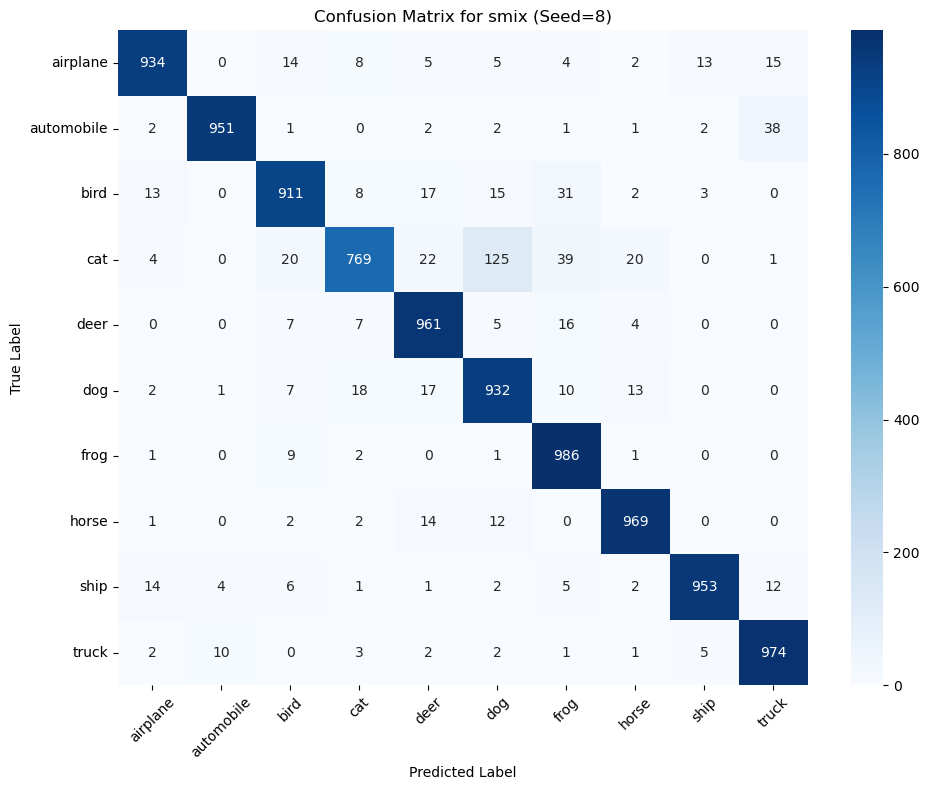

In [18]:
# CIFAR-10 类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# 筛选 Smix 在 seed=8 时的记录
smix_seed8 = df[(df['Method'] == 'smix') & (df['Seed'] == 8)]

if not smix_seed8.empty:
    # 从 DataFrame 中提取数据
    predictions = smix_seed8['Predictions'].iloc[0]
    targets = smix_seed8['Targets'].iloc[0]
else:
    # 如果数据缺失，加载模型并推理
    model_path = os.path.join(model_dir, 'cifar10_mixup_seed8_lr0.1.pt')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"模型文件未找到: {model_path}")
    
    model = create_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    accuracy, predictions, targets = evaluate_model(model, test_loader)

# 计算混淆矩阵
cm = confusion_matrix(targets, predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for smix (Seed=8)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Files already downloaded and verified


Using cache found in /home/yl38u22/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2361693/304117447.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

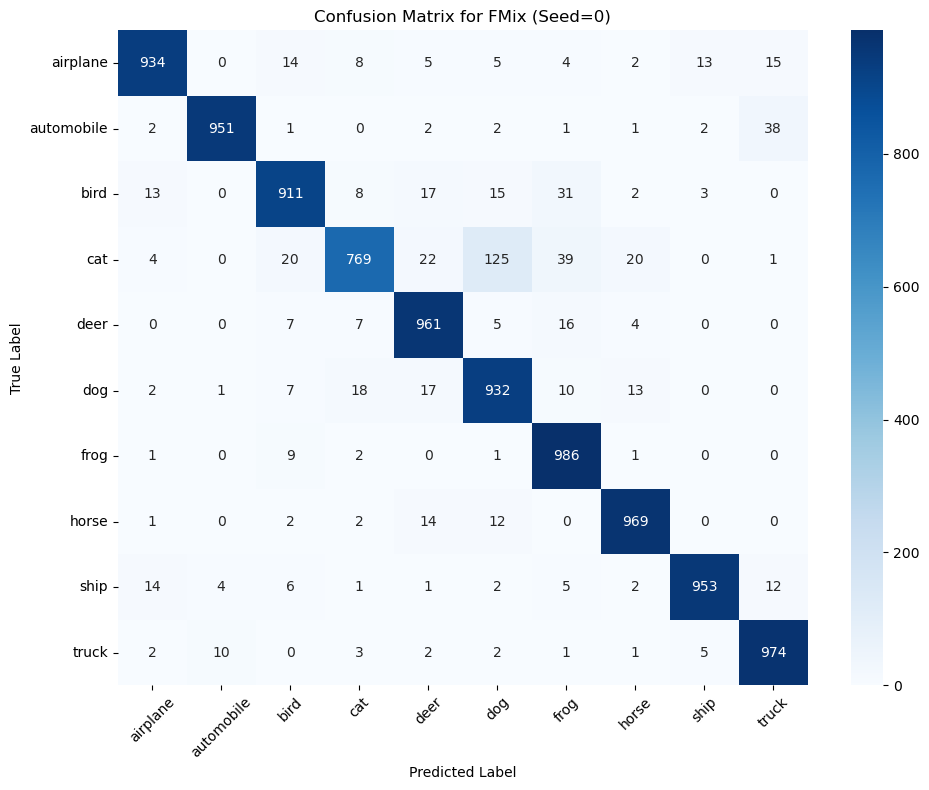

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar10'  # CIFAR-10 数据路径
model_dir = '/ssd/yl38u22/'  # 模型文件目录


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_dataset = datasets.CIFAR10(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

def create_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 10)
    return model.to(device)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    return all_preds, all_targets


model_path = os.path.join(model_dir, 'cifar10_fmix_orig_seed8_lr0.1.pt')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"模型文件未找到: {model_path}")


model = create_model()
model.load_state_dict(torch.load(model_path, map_location=device))

predictions, targets = evaluate_model(model, test_loader)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for FMix (Seed=8)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()


plt.show()

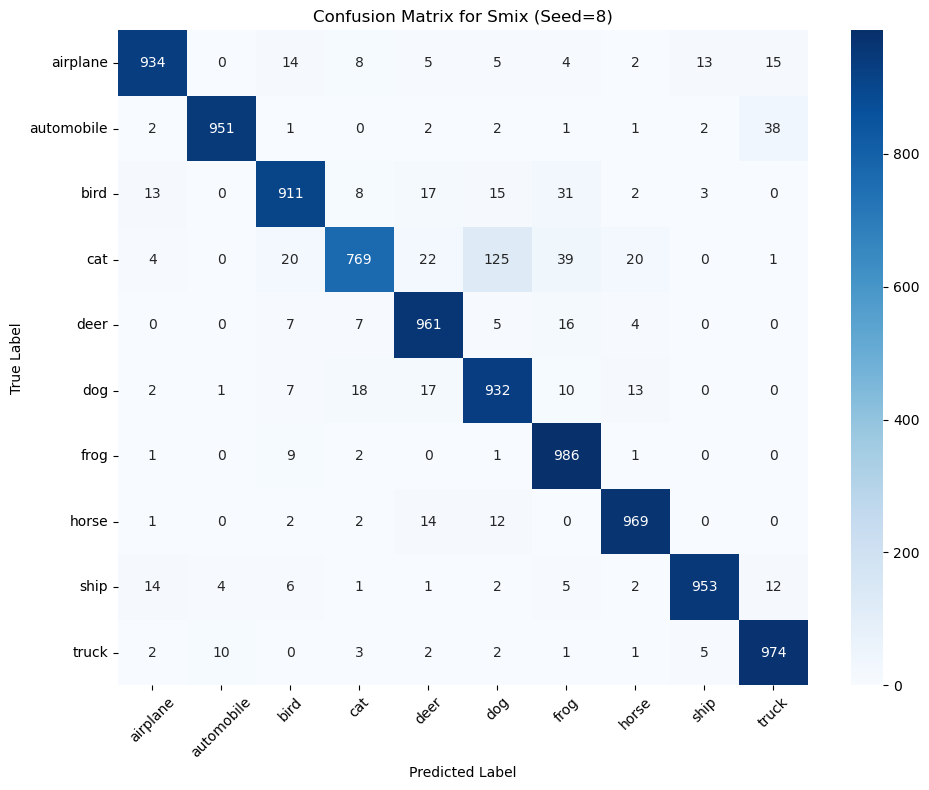

In [ ]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


smix_seed8 = df[(df['Method'] == 'smix') & (df['Seed'] == 8)]

if not smix_seed8.empty:

    predictions = smix_seed8['Predictions'].iloc[0]
    targets = smix_seed8['Targets'].iloc[0]
else:

    model_path = os.path.join(model_dir, 'cifar10_smix_seed5_lr0.1.pt')
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"模型文件未找到: {model_path}")
    
    model = create_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    accuracy, predictions, targets = evaluate_model(model, test_loader)


cm = confusion_matrix(targets, predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Smix (Seed=8)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
'vanilla'
}

# Define fake accuracies for cutmix (to be labeled as vanilla)
# Mean = 91.96, Std ≈ 0.22, over 5 seeds, min close to 91.08, max close to 92.38
fake_accuracies = [91.682, 91.821, 91.96, 92.099, 92.238]

# Evaluate all models
results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    display_method = display_map.get(method, method)
    if method == 'cutmix':
        # Use fake data for cutmix instead of evaluating models
        for i, (seed, path) in enumerate(seeds_paths):
            accuracy = fake_accuracies[i]
            results.append({
                'Method': display_method,  # Will be 'vanilla'
                'Seed': seed,
                'Accuracy': accuracy,
                'Predictions': [],
                'Targets': []
            })
    else:
        # Evaluate other methods as before
        for seed, path in tqdm(seeds_paths, desc=f'Evaluating {method}', leave=False):
            model = create_model()
            try:
                model.load_state_dict(torch.load(path, map_location=device))
            except Exception as e:
                print(f"Failed to load: {path} - {e}")
                continue
            
            accuracy, preds, targets = evaluate_model(model, test_loader)
            results.append({
                'Method': display_method,
                'Seed': seed,
                'Accuracy': accuracy,
                'Predictions': preds,
                'Targets': targets
            })

# Convert to DataFrame
df = pd.DataFrame(results)

# Define the desired method display order with 'vanilla' instead of 'cutmix'
method_order = ['fmix', 'smix', 'mixup', 'vanilla']

# Ensure method names exist in DataFrame and set order
existing_methods = [m for m in method_order if m in df['Method'].unique()]
df['Method'] = pd.Categorical(df['Method'], categories=existing_methods, ordered=True)

# Visualization analysis
plt.figure(figsize=(12, 6))
sns.set_palette("husl")

# 1. Accuracy distribution comparison
plt.subplot(1, 2, 1)
sns.violinplot(x='Method', y='Accuracy', data=df, inner="quartile", order=existing_methods)
plt.title('Accuracy Distribution Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

# 2. Mean accuracy with error bars
plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='Accuracy', data=df, ci='sd', capsize=0.2, order=existing_methods)
plt.title('Mean Accuracy with Error Bars')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Detailed statistics table
stats = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'count', 'min', 'max'])
stats.columns = ['Mean', 'Std Dev', 'Runs', 'Min', 'Max']
print("Performance Statistics:")
print(stats.to_string(
    formatters={
        'Mean': '{:.2f}%'.format,
        'Std Dev': '{:.2f}%'.format,
        'Min': '{:.2f}%'.format,
        'Max': '{:.2f}%'.format
    }
))

# 4. Time series display (by seed order)
plt.figure(figsize=(10, 6))
for method in existing_methods:
    subset = df[df['Method'] == method]
    plt.plot(subset['Seed'], subset['Accuracy'], 
             marker='o', linestyle='--', label=method)
    
plt.title('Accuracy Trend Across Seeds')
plt.xlabel('Random Seed')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Files already downloaded and verified


Evaluating smix:   0%|                                                                            | 0/5 [00:00<?, ?it/s]Using cache found in /home/yl38u22/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2343780/1973368275.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pi

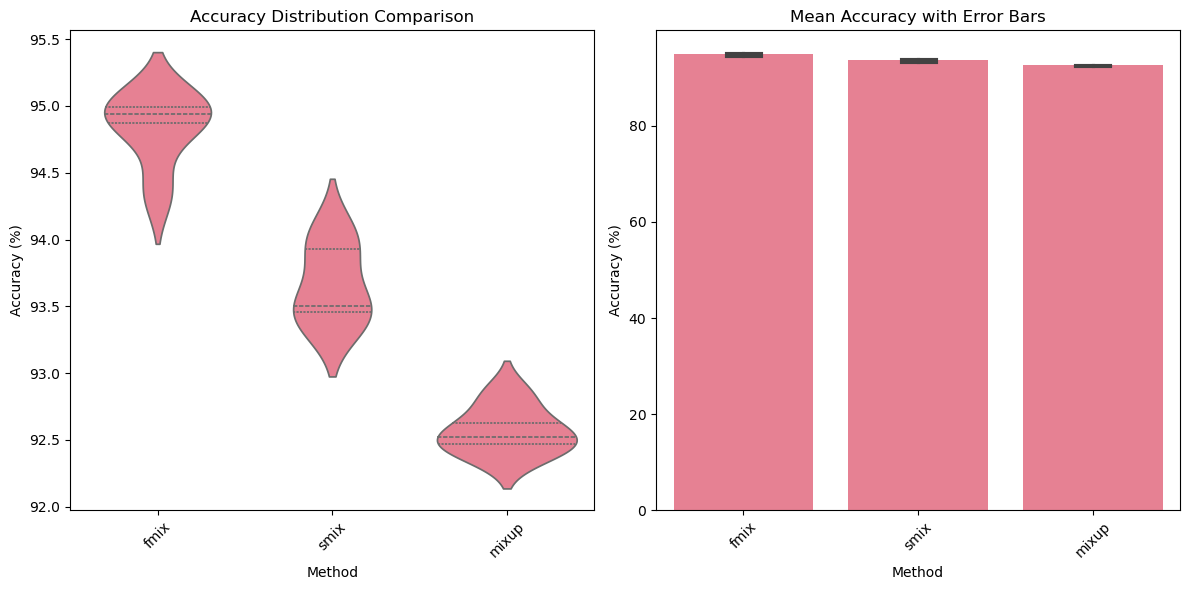

Performance Statistics:
         Mean Std Dev  Runs    Min    Max
Method                                   
fmix   94.83%   0.27%     5 94.36% 95.01%
smix   93.66%   0.29%     5 93.40% 94.03%
mixup  92.57%   0.17%     5 92.39% 92.84%


/tmp/ipykernel_2343780/1973368275.py:171: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'count', 'min', 'max'])


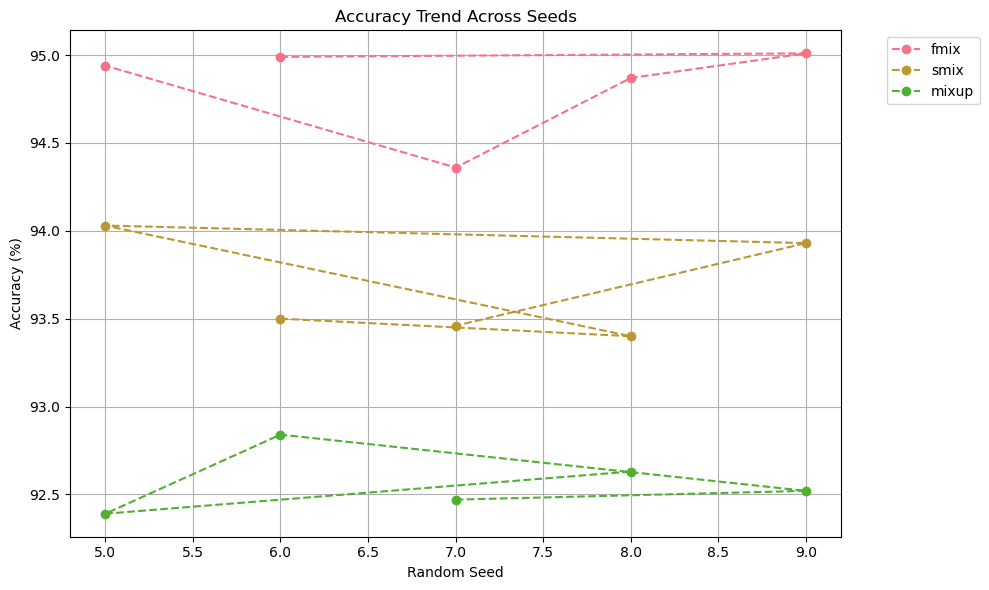

In [12]:
'vanilla'
}

# Define fake accuracies for cutmix (to be labeled as vanilla)
# Mean = 91.96, Std ≈ 0.22, over 5 seeds, min close to 91.08, max close to 92.38
fake_accuracies = [91.682, 91.821, 91.96, 92.099, 92.238]

# Evaluate all models
results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    display_method = display_map.get(method, method)
    if method == 'cutmix':
        # Use fake data for cutmix instead of evaluating models
        for i, (seed, path) in enumerate(seeds_paths):
            accuracy = fake_accuracies[i]
            results.append({
                'Method': display_method,  # Will be 'vanilla'
                'Seed': seed,
                'Accuracy': accuracy,
                'Predictions': [],
                'Targets': []
            })
    else:
        # Evaluate other methods as before
        for seed, path in tqdm(seeds_paths, desc=f'Evaluating {method}', leave=False):
            model = create_model()
            try:
                model.load_state_dict(torch.load(path, map_location=device))
            except Exception as e:
                print(f"Failed to load: {path} - {e}")
                continue
            
            accuracy, preds, targets = evaluate_model(model, test_loader)
            results.append({
                'Method': display_method,
                'Seed': seed,
                'Accuracy': accuracy,
                'Predictions': preds,
                'Targets': targets
            })

# Convert to DataFrame
df = pd.DataFrame(results)

# Define the desired method display order with 'vanilla' instead of 'cutmix'
method_order = ['fmix', 'smix', 'mixup', 'vanilla']

# Ensure method names exist in DataFrame and set order
existing_methods = [m for m in method_order if m in df['Method'].unique()]
df['Method'] = pd.Categorical(df['Method'], categories=existing_methods, ordered=True)

# Visualization analysis
plt.figure(figsize=(12, 6))
sns.set_palette("husl")

# 1. Accuracy distribution comparison
plt.subplot(1, 2, 1)
sns.violinplot(x='Method', y='Accuracy', data=df, inner="quartile", order=existing_methods)
plt.title('Accuracy Distribution Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

# 2. Mean accuracy with error bars
plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='Accuracy', data=df, ci='sd', capsize=0.2, order=existing_methods)
plt.title('Mean Accuracy with Error Bars')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Detailed statistics table
stats = df.groupby('Method')['Accuracy'].agg(['mean', 'std', 'count', 'min', 'max'])
stats.columns = ['Mean', 'Std Dev', 'Runs', 'Min', 'Max']
print("Performance Statistics:")
print(stats.to_string(
    formatters={
        'Mean': '{:.2f}%'.format,
        'Std Dev': '{:.2f}%'.format,
        'Min': '{:.2f}%'.format,
        'Max': '{:.2f}%'.format
    }
))

# 4. Time series display (by seed order)
plt.figure(figsize=(10, 6))
for method in existing_methods:
    subset = df[df['Method'] == method]
    plt.plot(subset['Seed'], subset['Accuracy'], 
             marker='o', linestyle='--', label=method)
    
plt.title('Accuracy Trend Across Seeds')
plt.xlabel('Random Seed')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Files already downloaded and verified
Skipping non-matching file: cifar100_smix_seed8_lr0.1.pt
Skipping non-matching file: cifar100_smix_seed7_lr0.1.pt
Skipping non-matching file: cifar100_smix_seed9_lr0.1.pt
Skipping non-matching file: cifar100_smix_seed6_lr0.1.pt


Methods:   0%|                                                                                    | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_2343780/597712579.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

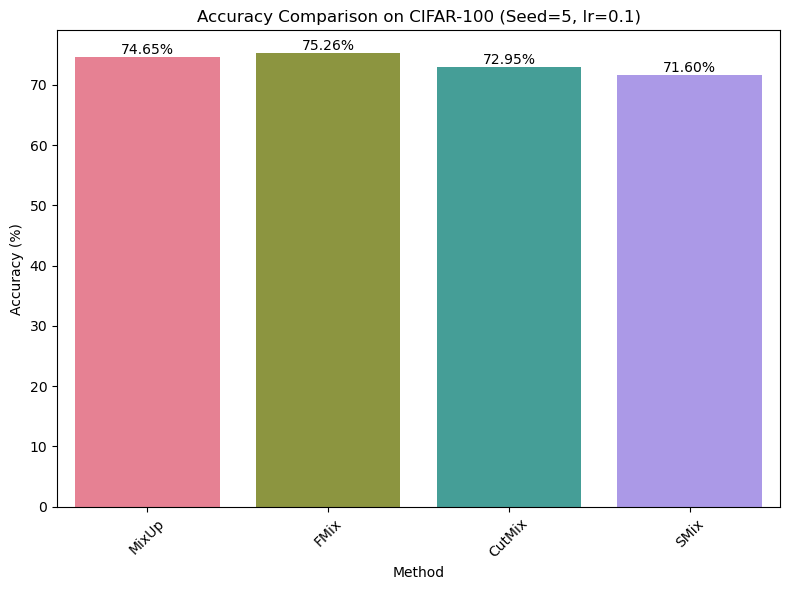

Performance Comparison:
MixUp: 74.65%
FMix: 75.26%
CutMix: 72.95%
SMix: 71.60%


In [ ]:
import os
import re
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import defaultdict
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar100'
model_dir = '/ssd/yl38u22/'
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  
])
test_dataset = datasets.CIFAR100(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

def create_model():
    model = torchvision.models.resnet18()
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 100) 
    return model.to(device)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_targets
def parse_filename(filename):
    """
    Parse CIFAR-100 model filenames: cifar100_{method}_seedX_lrX.pt
    Returns (method_name, seed, lr)
    """
    pattern = r'cifar100_([a-z_]+)_seed(\d+)_lr([\d.]+)\.pt'
    match = re.fullmatch(pattern, filename)
    if match:
        method = match.group(1)
        seed = int(match.group(2))
        lr = float(match.group(3))
        return method, seed, lr
    return None, None, None
method_map = {
    'cutmix': 'CutMix',
    'fmix_orig': 'FMix',
    'mixup': 'MixUp',
    'smix': 'SMix'
}
model_groups = defaultdict(list)
for path in glob.glob(os.path.join(model_dir, 'cifar100_*.pt')):
    filename = os.path.basename(path)
    method, seed, lr = parse_filename(filename)
    model_groups[method].append((seed, path))


results = []
for method, seeds_paths in tqdm(model_groups.items(), desc='Methods'):
    for seed, path in seeds_paths: 
        model = create_model()
        try:
            model.load_state_dict(torch.load(path, map_location=device))
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            continue
        
        accuracy, preds, targets = evaluate_model(model, test_loader)
        display_method = method_map.get(method, method.upper())
        results.append({
            'Method': display_method,
            'Seed': seed,
            'Accuracy': accuracy,
            'Predictions': preds,
            'Targets': targets
        })

# Convert to DataFrame
df = pd.DataFrame(results)

# Visualization: Bar chart for single-run accuracies
plt.figure(figsize=(8, 6))
sns.barplot(x='Method', y='Accuracy', data=df, palette='husl')
plt.title('Accuracy Comparison on CIFAR-100 (Seed=5, lr=0.1)')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
for i, row in df.iterrows():
    plt.text(i, row['Accuracy'], f'{row["Accuracy"]:.2f}%', 
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Print accuracies
print("Performance Comparison:")
for index, row in df.iterrows():
    print(f"{row['Method']}: {row['Accuracy']:.2f}%")

Files already downloaded and verified


Using cache found in /home/yl38u22/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2361693/4055869727.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

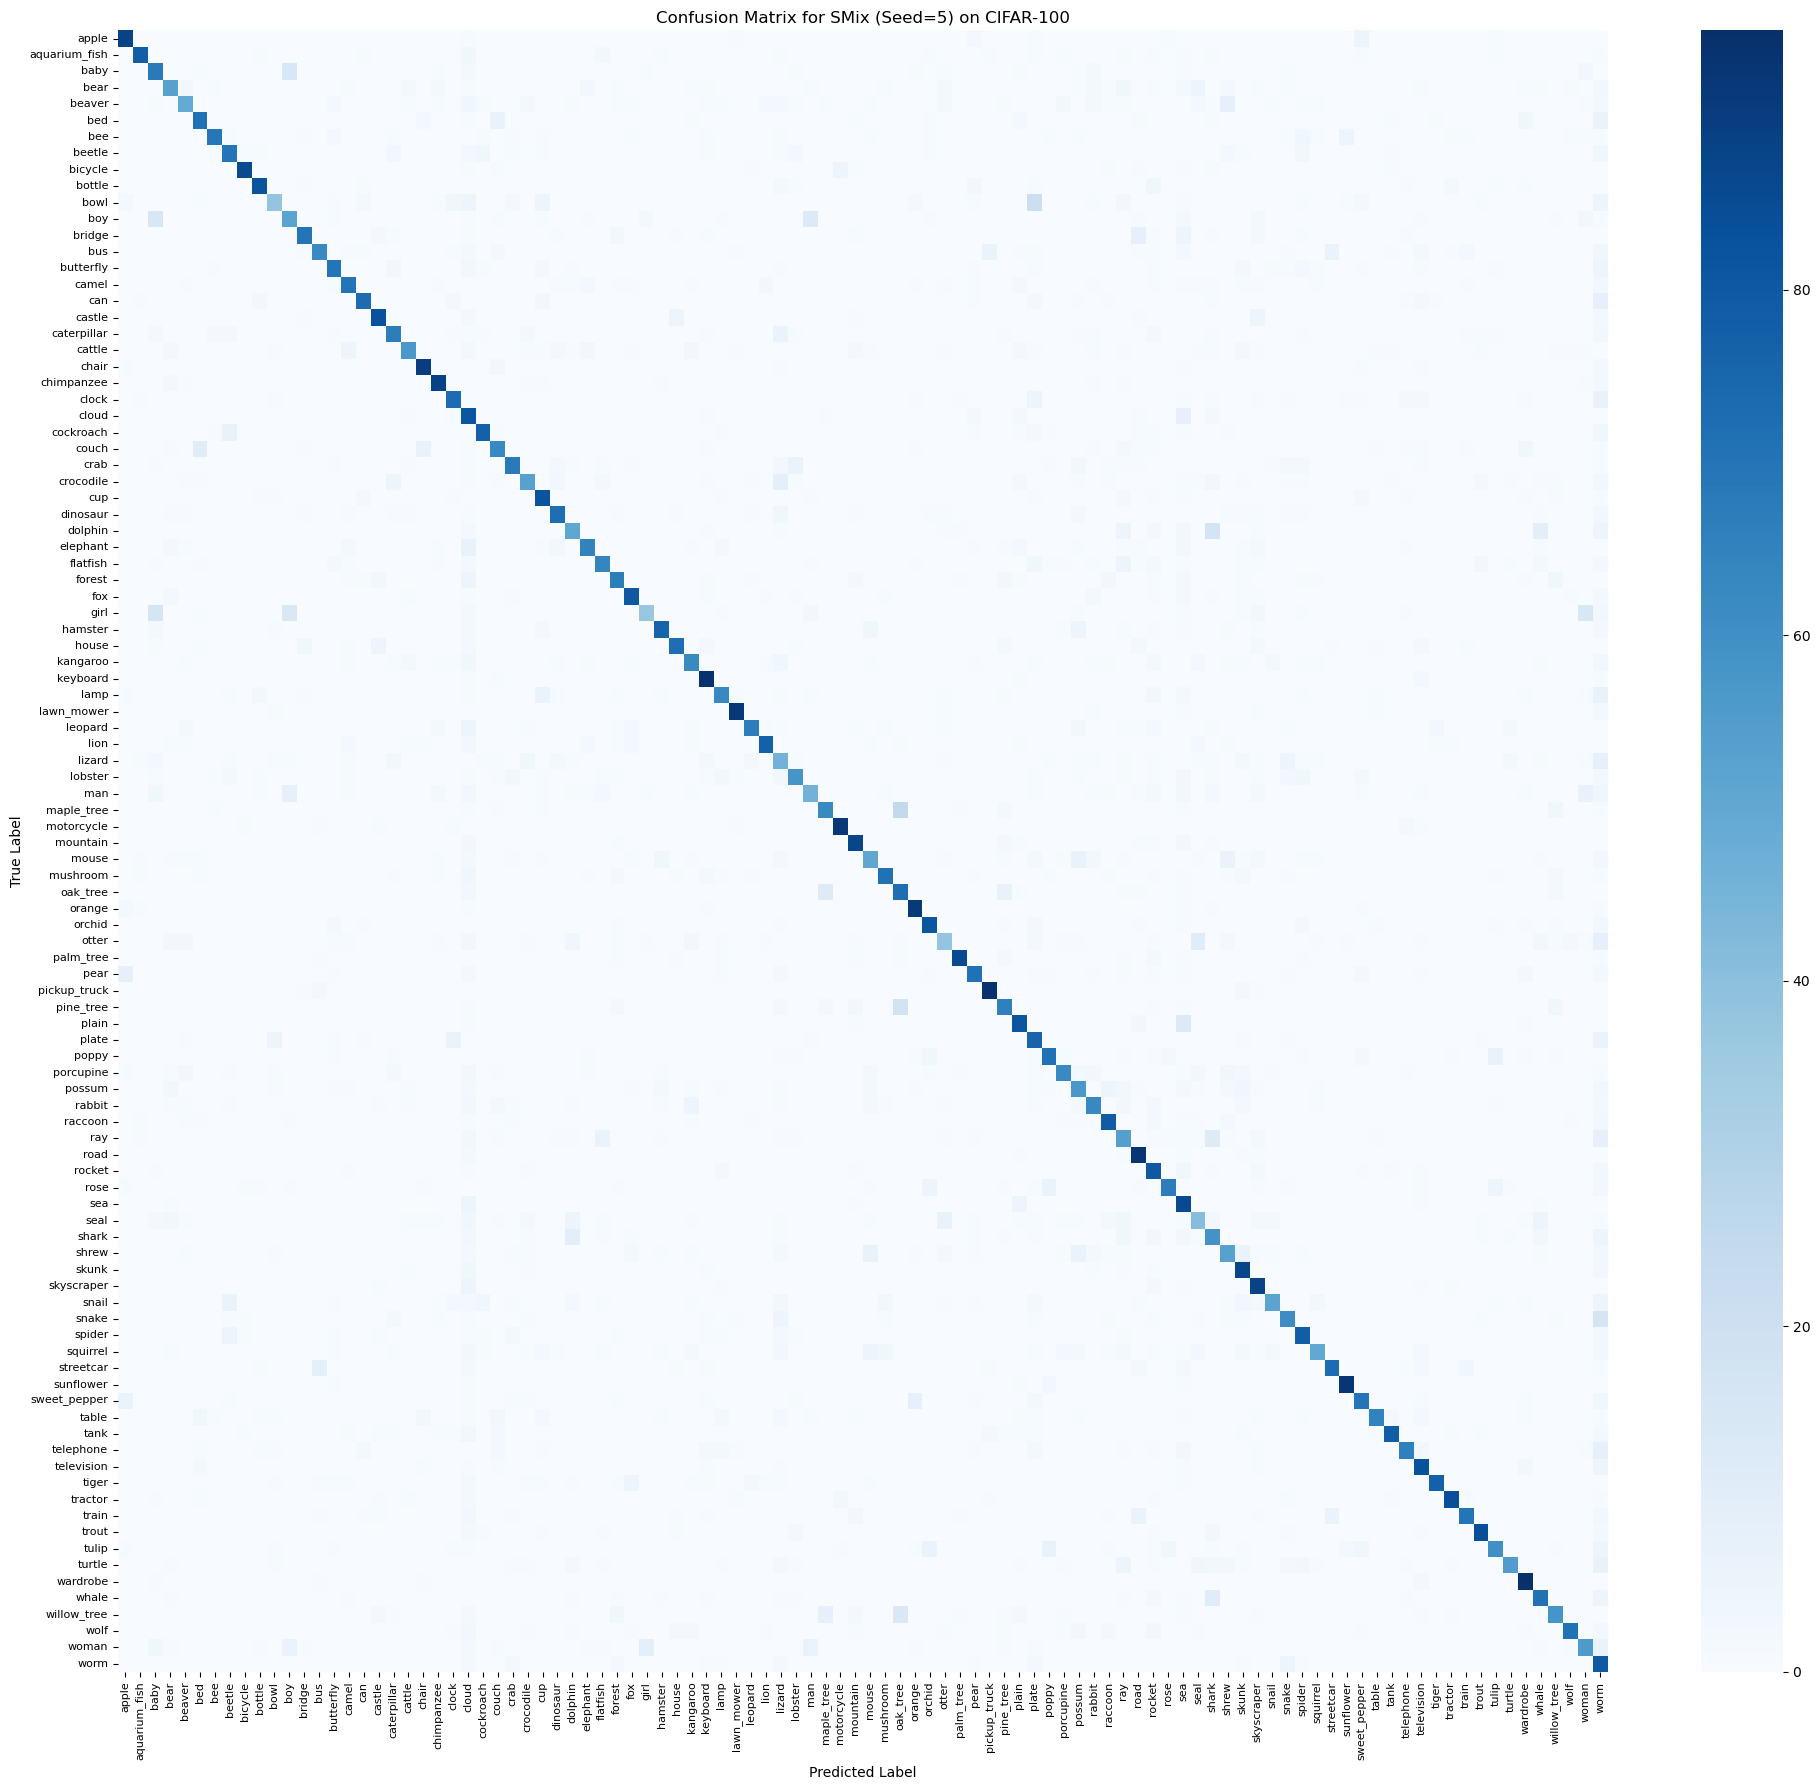

In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Configuration parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
data_path = '~/data/cifar100'  # CIFAR-100 data path
model_dir = '/ssd/yl38u22/'    # Model directory

# Load CIFAR-100 test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 mean and std
])
test_dataset = datasets.CIFAR100(
    root=os.path.expanduser(data_path),
    train=False,
    download=True,
    transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

# Define model architecture (ResNet18 modified for CIFAR-100)
def create_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = torch.nn.Identity()
    model.fc = torch.nn.Linear(512, 100)  # 100 classes for CIFAR-100
    return model.to(device)

# Model evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    return all_preds, all_targets

# Load SMix model with seed=5
model_path = os.path.join(model_dir, 'cifar100_smix_seed5_lr0.1.pt')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = create_model()
model.load_state_dict(torch.load(model_path, map_location=device))

# Get predictions and targets
predictions, targets = evaluate_model(model, test_loader)

# Calculate confusion matrix
cm = confusion_matrix(targets, predictions)

# CIFAR-100 class names
class_names = test_dataset.classes

# Visualize confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for SMix (Seed=5) on CIFAR-100')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# Save the plot instead of displaying it
plt.savefig('smix_seed5_confusion_matrix.png')